In [1]:
import rospy
from sensor_msgs.msg import Image
from std_srvs.srv import Trigger
import clover.srv

In [6]:
rospy.init_node('testNB', anonymous=True)
def capture():
    return rospy.wait_for_message('/main_camera/image_raw', Image, timeout=1.)

get_telemetry = rospy.ServiceProxy('get_telemetry', clover.srv.GetTelemetry)
navigate = rospy.ServiceProxy('navigate', clover.srv.Navigate)
navigate_global = rospy.ServiceProxy('navigate_global', clover.srv.NavigateGlobal)
set_position = rospy.ServiceProxy('set_position', clover.srv.SetPosition)
set_velocity = rospy.ServiceProxy('set_velocity', clover.srv.SetVelocity)
set_attitude = rospy.ServiceProxy('set_attitude', clover.srv.SetAttitude)
set_rates = rospy.ServiceProxy('set_rates', clover.srv.SetRates)
land = rospy.ServiceProxy('land', Trigger)

In [4]:
def take_off():
    set_position(z=1.5, frame_id='map', auto_arm=True)
take_off()

In [8]:
import cv2, numpy as np
from cv_bridge import CvBridge
from matplotlib import pyplot as plt

(240, 320, 3)


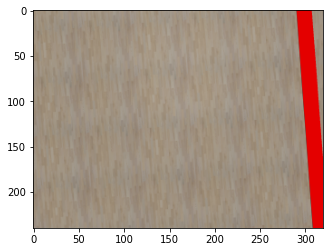

In [10]:
bridge = CvBridge()
def image():
    msg = capture()
    return bridge.imgmsg_to_cv2(msg,desired_encoding='bgr8')
def show(img, **kwargs):
    plt.imshow(img[...,::-1], **kwargs)

img = image()
print(img.shape)
show(img)

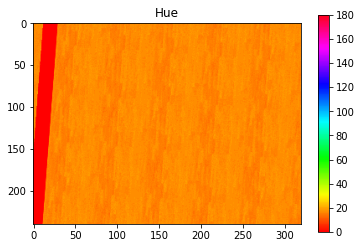

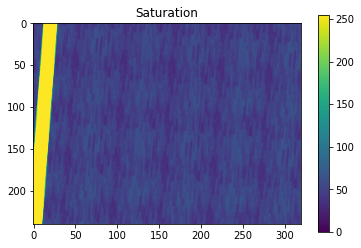

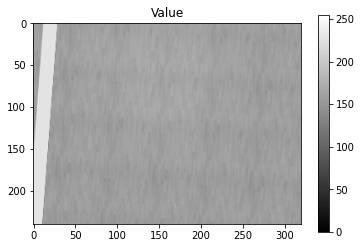

In [22]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hue, sat, val = np.moveaxis(hsv, -1, 0)

show(hue,vmin=0,vmax=180,cmap='hsv')
plt.title("Hue")
plt.colorbar()
plt.show()

show(sat,vmin=0,vmax=255)
plt.title("Saturation")
plt.colorbar()
plt.show()

show(val,vmin=0,vmax=255,cmap='gray')
plt.title("Value")
plt.colorbar()
plt.show()

In [ ]:
# -- Angle Utils -- #

def angle_dist(a, b):
    "Calculates the acute distance between two angles in degrees."
    dist = (a - b) % (2*np.pi)
    return np.where(dist <= np.pi, dist, 2*np.pi - dist)


def angle_diff(a, b):
    "Calculates the acute difference between two angles in degrees."
    dist = (a - b) % (2*np.pi)
    return np.where(dist <= np.pi, dist, dist - 2*np.pi)


def recenter(angles, mid_angle):
    return np.mod(angles - mid_angle + np.pi, 2*np.pi) + mid_angle - np.pi


def search_by_angle(diff, angle):
    angles = np.arctan2(diff[:, 1], diff[:, 0])
    return np.argmin(angle_dist(angles, angle))

In [43]:
# -- Probabilistic Masking (Null Hypothesis test) -- #
import scipy.stats


def pval(dist, points):
    "Returns the p-value of points on a symmetric distribution."
    cumul = dist.cdf(points)
    return 2*np.minimum(cumul, 1-cumul)


def pval_lower(dist, points):
    "Returns the lower p-value of points on a distribution."
    return dist.cdf(points)


def pval_upper(dist, points):
    "Returns the upper p-value of points on a distribution."
    return dist.sf(points)


def recenter_hue(hue, mid_hue):
    return np.mod(hue - mid_hue + 90, 180) + mid_hue - 90


RED_FILTER = {
    'hue_mean': 0,
    'hue_std': 5,
    'sat_offs': 0,
    'sat_std': -5,
    'val_offs': 20,
    'val_std': -50,
}


class Filter:
    def __init__(self, hue_mean=0, hue_std=5, sat_offs=0, sat_std=5, val_offs=0, val_std=5):
        self.hue_dist = scipy.stats.norm(hue_mean, hue_std)
        self.sat_dist = scipy.stats.expon(sat_offs, np.abs(sat_std))
        self.val_dist = scipy.stats.expon(val_offs, np.abs(val_std))
        self.sat_inv = sat_std < 0
        self.val_inv = val_std < 0

    def apply_hue(self, hue):
        return pval(self.hue_dist, recenter_hue(hue, self.hue_dist.mean()))

    def apply_sat(self, sat):
        return pval_upper(self.sat_dist, 255 - sat if self.sat_inv else sat)

    def apply_val(self, val):
        return pval_upper(self.val_dist, 255 - val if self.val_inv else val)

    def apply(self, hsv):
        hue, sat, val = np.moveaxis(hsv.astype(float), -1, 0)
        pval_hue = self.apply_hue(hue)
        pval_sat = self.apply_sat(sat)
        pval_val = self.apply_val(val)
        return pval_hue * pval_sat * pval_val

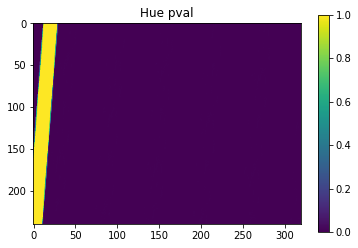

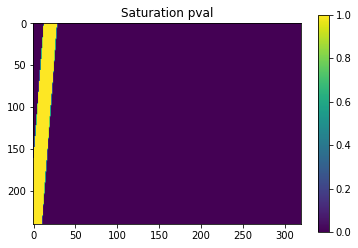

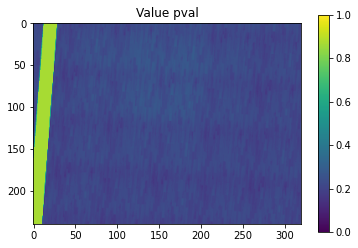

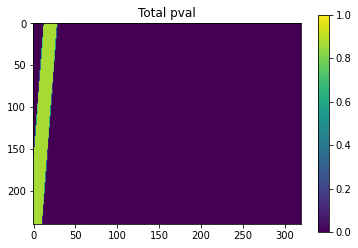

In [44]:
red_filter = Filter(**RED_FILTER)

pval_hue = red_filter.apply_hue(hue)
show(pval_hue, vmin=0, vmax=1)
plt.title("Hue pval")
plt.colorbar()
plt.show()

pval_sat = red_filter.apply_sat(sat)
show(pval_sat, vmin=0, vmax=1)
plt.title("Saturation pval")
plt.colorbar()
plt.show()

pval_val = red_filter.apply_val(val)
show(pval_val, vmin=0, vmax=1)
plt.title("Value pval")
plt.colorbar()
plt.show()

pval_tot = pval_hue * pval_sat * pval_val
show(pval_tot, vmin=0, vmax=1)
plt.title("Total pval")
plt.colorbar()
plt.show()

Contours found: 1


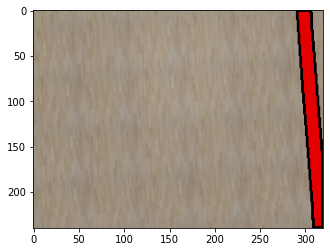

In [53]:
_, mask_boundary = cv2.threshold(pval_tot, 0.65, 1.0, cv2.THRESH_BINARY)
mask_boundary = (mask_boundary * 255).astype(np.uint8)
contours, hierarchy = cv2.findContours(mask_boundary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
img_copy = img.copy()
cv2.drawContours(img_copy, contours, -1, (0,0,0), 2)
print("Contours found:", len(contours))
show(img_copy)

In [57]:
center = np.array(img.shape[:2])/2
cv2.pointPolygonTest(contours[0], center, True)

-182.6503459277886

In [62]:
WIDTH = 320
HEIGHT = 240
def idx_to_xy(idx):
    return idx[...,::-1] * (1,-1) + (0, HEIGHT)
def xy_to_idx(xy):
    return ((xy - (0, HEIGHT)) * (1,-1))[...,::-1]
def to_cv(idx):
    return np.round(idx[...,::-1]).astype(int).clip(-9999, 9999)

In [63]:
def L2_2(x):
    # Return the L2 (euclidean) norm squared
    return np.inner(x, x)

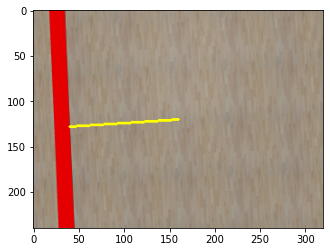

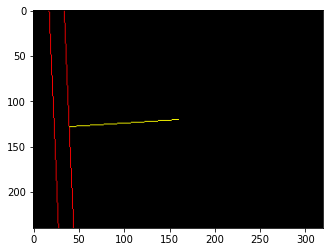

In [105]:
img = image()
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
filter = red_filter.apply(hsv)
filter_img = (filter * 255).astype(np.uint8)
edges = cv2.Canny(filter_img, 20, 240)

edges_idx = np.moveaxis(np.indices(edges.shape),0,-1)[edges>127].reshape(-1,2)
edges_xy = idx_to_xy(edges_idx)

# Draw edge points
img_edges = np.zeros_like(img)
img_edges[tuple(xy_to_idx(edges_xy).astype(int).clip((0,0),(HEIGHT-1,WIDTH-1)).T)] = (0, 0, 255)

# Find closest point
center_idx = np.array(img.shape[:2])/2
center_xy = idx_to_xy(center)

closest_pt_xy = edges_xy[np.argmin(np.linalg.norm(edges_xy - center_xy, axis=-1))] 
closest_pt_idx = xy_to_idx(closest_pt_xy)

# Draw line to closest point
img_copy = img.copy()
cv2.line(img_copy, to_cv(center_idx), to_cv(closest_pt_idx), (0,255,255), 2)
cv2.line(img_edges, to_cv(center_idx), to_cv(closest_pt_idx), (0,255,255), 1)

show(img_copy)
plt.show()
show(img_edges)

In [106]:
dx,dy = closest_pt_xy - center_xy
dir = np.array((dx, dy))
dir_unit = dir / np.linalg.norm(dir)
dir_unit

array([-0.99778516, -0.06651901])

In [107]:
SPEED = 1 # m / s
vx, vy = SPEED * dir_unit
set_velocity(vx=vx, vy=vy, frame_id='body')

success: True
message: ''